<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 50px"><b>But de ce Notebook</b></h2>
<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Ce notebook a pour but d'analyser l'évolution du reste à charge (RAC) par région en France, tel que défini par le ticket modérateur et les dépassements d'honoraires. Il est crucial de noter que ce RAC représente le montant maximal que les sociétés d'assurances sont susceptibles de rembourser en cas de sinistre. Nous étudierons comment cette part des soins potentiellement remboursables en intégralité par les sociétés d'assurances, comme Allianz, a évolué au fil des ans à travers les régions françaises, et nous y ajouterons des prédictions pour 2025 et 2026.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Dictionnaires régionaux nécessaires</h2>

In [35]:
region_mapping = {
    5: "Régions et Départements d'outre-mer",
    11: "Ile-de-France",
    24: "Centre-Val-de-Loire",
    27: "Bourgogne-Franche-Comté",
    28: "Normandie",
    32: "Hauts-de-France",
    44: "Grand Est",
    52: "Pays de la Loire",
    53: "Bretagne",
    75: "Nouvelle-Aquitaine",
    76: "Occitanie",
    84: "Auvergne-Rhône-Alpes",
    93: "Provence-Alpes-Côte d'Azur et Corse"
}


aux_region_mapping = {
    "Régions et Départements d'outre-mer": "Régions et Départements d'outre-mer",
    "Ile-de-France": "Ile-de-France",
    "Centre-Val-de-Loire": "Centre-Val-de-Loire",
    "Bourgogne-Franche-Comté": "Bourgogne-Franche-Comté",
    "Normandie": "Normandie",
    "Hauts-de-France": "Grand Est et Hauts-de-France",
    "Grand Est": "Grand Est et Hauts-de-France",
    "Pays de la Loire": "Pays de la Loire",
    "Bretagne": "Bretagne",
    "Nouvelle-Aquitaine": "Nouvelle-Aquitaine",
    "Occitanie": "Occitanie",
    "Auvergne-Rhône-Alpes": "Auvergne-Rhône-Alpes",
    "Provence-Alpes-Côte d'Azur et Corse": "Provence-Alpes-Côte d'Azur et Corse"
}

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Importation des librairies nécessaires</h2>

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, gamma
from sklearn.metrics import mean_absolute_percentage_error
import warnings
from utils import get_demography_data_by_sexe_age_region
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.simplefilter('ignore', category=UserWarning)


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Chargement des données et leurs visualisations</h2>

In [37]:
df = pd.read_csv("./DBs/RAC_nouveau_GLM.csv")


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Aperçu des données</h2>

In [38]:
df.head()

,SOI_ANN,SOI_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,2019.0,1.0,0.0,80.0,11.0,1.834800e+02,4.783700e+02,2.948900e+02
1,2019.0,1.0,0.0,99.0,24.0,2.160000e+00,6.330000e+00,4.170000e+00
2,2019.0,1.0,1.0,0.0,5.0,6.438103e+06,2.085032e+07,1.441221e+07
3,2019.0,1.0,1.0,0.0,11.0,4.546379e+07,1.244164e+08,7.895265e+07
4,2019.0,1.0,1.0,0.0,24.0,7.438699e+06,2.041042e+07,1.297172e+07



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Changement de types des variables</h2>

In [39]:
df = df.astype({
    'AGE_BEN_SNDS': 'int32',
    'BEN_SEX_COD': 'int32',
    'BEN_RES_REG': 'int32',
    'SOI_ANN': 'int32',
    'SOI_MOI': 'int32'
})
df.head()

,SOI_ANN,SOI_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,2019,1,0,80,11,1.834800e+02,4.783700e+02,2.948900e+02
1,2019,1,0,99,24,2.160000e+00,6.330000e+00,4.170000e+00
2,2019,1,1,0,5,6.438103e+06,2.085032e+07,1.441221e+07
3,2019,1,1,0,11,4.546379e+07,1.244164e+08,7.895265e+07
4,2019,1,1,0,24,7.438699e+06,2.041042e+07,1.297172e+07


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Filtrage des données</h2>

In [40]:

# Renommer les colonnes pour une meilleure lisibilité
df.rename(columns = {'SOI_ANN':'annee', 'SOI_MOI':'mois','AGE_BEN_SNDS': 'age', 
                    'BEN_RES_REG': 'region', 'BEN_SEX_COD': 'sexe', 
                    'FLT_PAI_MNT': 'PAI', 'FLT_REM_MNT': 'REM'}, inplace = True)

# Appliquer le mapping pour convertir les codes de région en noms de région
df['region'] = df['region'].map(region_mapping)

# Appliquer un second mapping pour l'agrégation des régions
df['region'] = df['region'].map(aux_region_mapping)

# Agréger les données par année et région en sommant les valeurs
# On supprime les colonnes non nécessaires pour l'agrégation
df_grouped = df.drop(columns = ['PAI', 'REM', 'age', 'mois', 'sexe']).groupby(by = ['annee', 'region']).sum()

# Remettre annee et region comme colonnes (plutôt qu'index)
df_grouped.reset_index(inplace=True)

# Filtrer pour ne garder que les données à partir de 2019
df_grouped = df_grouped[df_grouped['annee'] >= 2019]


# Afficher le dataframe résultant
df_grouped


,annee,region,RAC
0,2019,Auvergne-Rhône-Alpes,4.386474e+09
1,2019,Bourgogne-Franche-Comté,1.433603e+09
2,2019,Bretagne,1.539924e+09
3,2019,Centre-Val-de-Loire,1.288281e+09
4,2019,Grand Est et Hauts-de-France,6.465658e+09
...,...,...,...
67,2024,Nouvelle-Aquitaine,3.767533e+09
68,2024,Occitanie,3.877676e+09
69,2024,Pays de la Loire,2.123262e+09
70,2024,Provence-Alpes-Côte d'Azur et Corse,3.983276e+09


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Importation des données démographiques issues de <b>l'INSEE</b></h2>

In [41]:
year_population_dataframes = {}
for year in range(2018, 2025):  # Boucle sur les années de 2018 à 2024
    # Chargement des données démographiques pour chaque année en utilisant la fonction importée
    year_population_dataframes[year] = get_demography_data_by_sexe_age_region.load_demography_data(year, aux_region_mapping)
    
    # Renommage des colonnes pour correspondre au format du dataframe principal
    year_population_dataframes[year].rename(columns={'Région': 'region', 'Annee': 'annee', 'Population': 'population'}, inplace=True)
    
    # Agrégation des données par année et région en sommant les populations
    # On supprime les colonnes 'Sexe' et 'Tranche d'âge' qui ne sont pas nécessaires pour cette analyse
    year_population_dataframes[year] = year_population_dataframes[year].drop(columns=['Sexe', 'Tranche d\'âge']).groupby(by=['annee', 'region']).sum().reset_index() 

# Concaténation de tous les dataframes en un seul
all_data = pd.concat(year_population_dataframes.values())

# Affichage du dataframe résultant
all_data

,annee,region,population
0,2018,Auvergne-Rhône-Alpes,7238642.4
1,2018,Bourgogne-Franche-Comté,2525022.0
2,2018,Bretagne,3019368.6
3,2018,Centre-Val-de-Loire,2315862.0
4,2018,Grand Est et Hauts-de-France,10405049.4
...,...,...,...
7,2024,Nouvelle-Aquitaine,5572088.1
8,2024,Occitanie,5581428.3
9,2024,Pays de la Loire,3543047.1
10,2024,Provence-Alpes-Côte d'Azur et Corse,5041574.1


Fusion des données de l'Open Damir avec les données démographiques

In [42]:
# Création d'une copie du dataframe des RAC par région/année
copied_df = df_grouped.copy()

# Fusion des dataframes des RAC avec les données démographiques
# On utilise une jointure 'inner' pour garder toutes les lignes communes entre les deux dataframes
final_df = copied_df.merge(all_data, how = 'inner', on= ['annee', 'region'], suffixes=('', '_new'))

# Ajustement de la population (facteur d'ajustement de 0.9)
# Ce facteur peut représenter une correction pour la population couverte par l'assurance
final_df['population'] = final_df['population'].astype(float) * 0.9

# Conversion du reste à charge en type float
final_df['RAC'] = final_df['RAC'].astype(float)

# Calcul du reste à charge moyen par personne
# Cette métrique est importante pour normaliser les coûts par rapport à la population
final_df['RAC_par_personne'] = final_df['RAC'] / final_df['population'] 

# Affichage du dataframe final
final_df


,annee,region,RAC,population,RAC_par_personne
0,2019,Auvergne-Rhône-Alpes,4.386474e+09,6543708.12,670.334664
1,2019,Bourgogne-Franche-Comté,1.433603e+09,2269372.95,631.717777
2,2019,Bretagne,1.539924e+09,2732806.35,563.495367
3,2019,Centre-Val-de-Loire,1.288281e+09,2085639.03,617.691177
4,2019,Grand Est et Hauts-de-France,6.465658e+09,9363911.85,690.486888
...,...,...,...,...,...
67,2024,Nouvelle-Aquitaine,3.767533e+09,5014879.29,751.270844
68,2024,Occitanie,3.877676e+09,5023285.47,771.940297
69,2024,Pays de la Loire,2.123262e+09,3188742.39,665.861993
70,2024,Provence-Alpes-Côte d'Azur et Corse,3.983276e+09,4537416.69,877.873057


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Visualisation du reste à charge par région</h2>

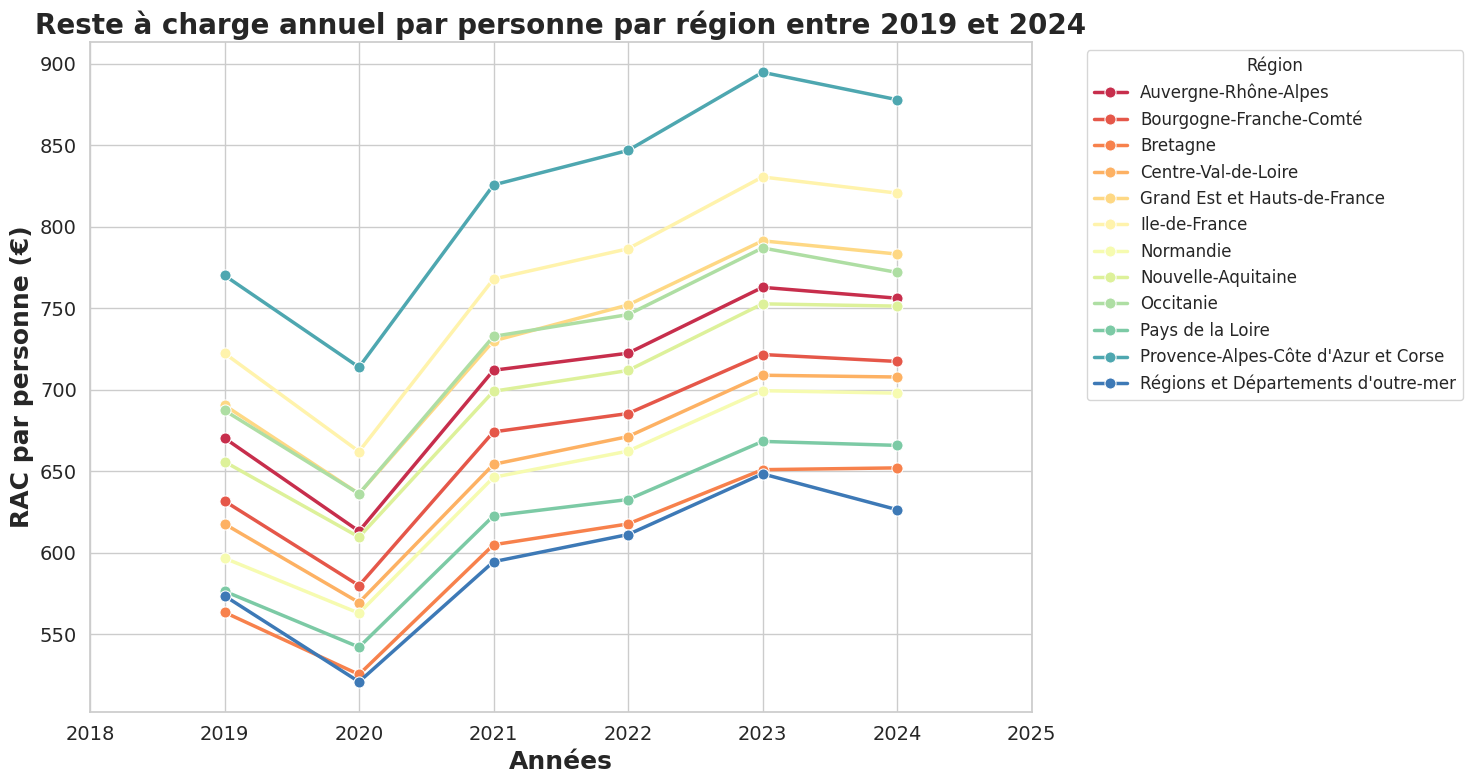

In [43]:
# Définir le style de la visualisation
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Tracer une courbe pour visualiser le reste à charge (RAC) par région entre 2019 et 2024
sns.lineplot(
    x="annee",  # Axe des x : années
    y="RAC_par_personne",  # Axe des y : reste à charge (RAC)
    data=final_df,  # Données utilisées pour la visualisation
    hue="region",  # Différencier les courbes par région
    marker='o',  # Ajouter des marqueurs pour chaque point
    markersize=8,  # Taille des marqueurs
    linewidth=2.5,  # Épaisseur des lignes
    errorbar=None,  # Pas de barres d'erreur
    estimator=np.sum,  # Estimation basée sur la somme des valeurs
    palette="Spectral"  # Palette de couleurs pour différencier les régions
)

# Ajouter un titre avec une taille de police plus grande
plt.title("Reste à charge annuel par personne par région entre 2019 et 2024", fontsize=20, fontweight='bold')

# Ajouter des étiquettes aux axes avec une taille de police plus grande
plt.xlabel("Années", fontsize=18, fontweight='bold')
plt.ylabel("RAC par personne (€)", fontsize=18, fontweight='bold')

# Ajuster la taille des ticks des axes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Ajuster les limites de l'axe des x pour inclure les années de 2018 à 2025
plt.xlim(2018, 2025)

# Placer la légende en dehors du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Région", fontsize=12)

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création de la base de données</b></h2>

In [44]:
def get_all_data_beginning_from_year(current_year, ending_year= 2024): 
    return final_df[(ending_year >= final_df['annee']) & (final_df['annee'] >= current_year)].sort_values(by=['annee',  'region'])

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Conception du GLM</b></h2>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Choix de la loi de probabilité que suit le reste à charge par personne</h2>

Code pour la visualisation de la distribution des données

In [45]:
def get_hist_from_data_beginning_from_year(year): 
    df = get_all_data_beginning_from_year(year)
    sns.histplot(data=df, x="RAC_par_personne",stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step")
    plt.title(f'Histogramme du reste à charge par personne à partir de l\'année {year}')
    return 

Q-Q plot pour le choix de la loi exponentielle adéquate au données

In [46]:
def get_q_q_plots(year):

    data = get_all_data_beginning_from_year(year)['RAC_par_personne']

    # Q-Q plot vs normal
    mu, sigma = stats.norm.fit(data)
    stats.probplot(data, dist="norm", sparams=(mu, sigma), plot=plt)
    plt.title("Q-Q Plot vs Fitted Normal (μ, σ)")
    plt.grid()
    plt.show()


    # Q-Q plot vs gamma*
    params = stats.gamma.fit(data)
    fig = qqplot(data, dist=stats.gamma, distargs=params, line='45', fit=True, alpha=0.5, marker='o', markersize=5)
    plt.title("Q-Q Plot against Gamma Distribution")
    plt.grid()
    plt.show()

    return 


Test statistique de Kolmogorov Smirnov pour l'ajustement des données à une loi normale / gamma.

In [47]:
def apply_kolmogorov_smirnov(data): 
    # Ajouter une constante pour rendre les données positives pour les distributions positives
    print("Effectuer le test de Kolmogorov-Smirnov pour différentes distributions...")

    # Test de Kolmogorov-Smirnov pour la distribution normale
    normal_test = kstest(data, 'norm', args=(data.mean(), data.std()))

    # Test de Kolmogorov-Smirnov pour la distribution gamma
    gamma_params = gamma.fit(data)
    gamma_test = kstest(data, 'gamma', args=gamma_params)

    # Test de Kolmogorov-Smirnov pour la distribution inverse gaussienne
    invgauss_params = stats.invgauss.fit(data, floc=0)
    invgauss_test = kstest(data, 'invgauss', args=invgauss_params)

    # Test de Kolmogorov-Smirnov pour la distribution Tweedie
    tweedie_params = sm.families.Tweedie(var_power=1.5).starting_mu(data)
    tweedie_test = kstest(data, 'gamma', args=(tweedie_params,))

    # Déterminer la meilleure distribution avec un seuil de confiance de 95 %
    results = {
        'normale': normal_test,
        'gamma': gamma_test,
        'inverse_gaussienne': invgauss_test,
        'tweedie': tweedie_test
    }
    
    # Filtrer les distributions avec une p-value > 0.05
    best_fit = {dist: f"p-value du test de Kolmogorov-Smirnov : {round(float(test.pvalue) * 100, 2)}%" 
                for dist, test in results.items() if test.pvalue > 0.01}
    
    if best_fit:
        print("Les distributions suivantes conviennent aux données :")
        for dist, result in best_fit.items():
            print(f"- {dist} : {result}")
    else:
        print("Aucune distribution ne convient aux données avec un seuil de confiance de 99 %.")

    return

In [48]:
# Application des tests statistiques 
data = get_all_data_beginning_from_year(2019)
apply_kolmogorov_smirnov(data['RAC_par_personne'])

Effectuer le test de Kolmogorov-Smirnov pour différentes distributions...
Les distributions suivantes conviennent aux données :
- normale : p-value du test de Kolmogorov-Smirnov : 96.97%
- gamma : p-value du test de Kolmogorov-Smirnov : 99.83%
- inverse_gaussienne : p-value du test de Kolmogorov-Smirnov : 99.9%


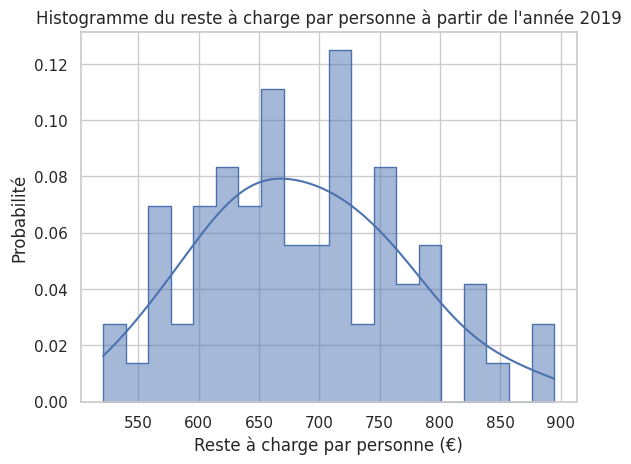

In [49]:
year = 2019
get_hist_from_data_beginning_from_year(year)
plt.xlabel("Reste à charge par personne (€)")
plt.ylabel("Probabilité")
plt.show()

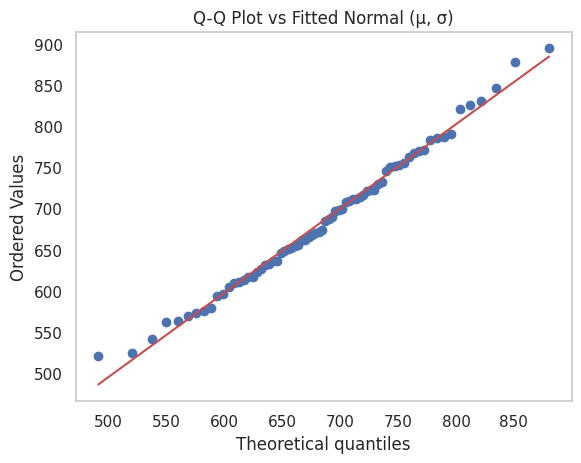

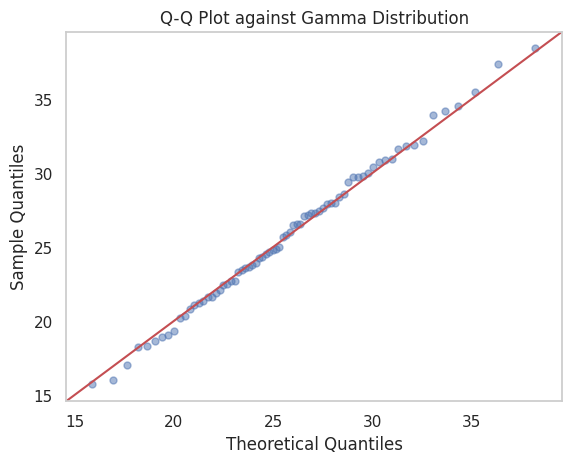

In [50]:
## q-q plots
get_q_q_plots(year)

**Remarque** : La loi normale est la meilleure distribution pour laquelle l’hypothèse nulle du test de Kolmogorov-Smirnov n’est pas rejetée à un niveau de confiance de 95 %. De plus, le q-q plot et l'histogramme valide le choix de la loi normale

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Nous construirons un modèle GLM (Modèle Linéaire Généralisé) en utilisant la famille de distribution Gaussienne et une fonction de lien identité. Ce choix maximisera la facilité d'interprétation des résultats de notre modèle.</h2>

In [51]:
def GLM_model(year, ending_year= 2024):

    # Récupérer les données filtrées pour la période spécifiée (de 'year' à 'ending_year')
    df_GLM = get_all_data_beginning_from_year(year, ending_year)
    
    # Encoder les variables catégorielles (régions) en utilisant one-hot encoding
    X = pd.get_dummies(df_GLM, columns=['region'], dtype=int)
    
    # Supprimer la région Ile-de-France pour éviter la multicolinéarité (référence)
    X.drop(columns=['region_Ile-de-France'], inplace=True)
    
    # Ajouter une constante pour l'intercept du modèle
    X = sm.add_constant(X)
    
    # Définir la variable cible (le reste à charge par personne)
    y = X['RAC_par_personne']
    
    # Créer le modèle GLM avec une famille de distribution Gaussienne
    # Exclure les colonnes non utilisées comme prédicteurs (RAC, population et la variable cible)
    glm_model = sm.GLM(y, sm.add_constant(X.drop(columns=['RAC_par_personne', 'RAC', 'population'])), 
                       family=sm.families.Gamma(sm.families.links.Identity()))
    
    # Ajuster le modèle aux données
    glm_results = glm_model.fit()

    return glm_model, glm_results


In [52]:
glm_model, glm_results = GLM_model(year)
# Résultats du model
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       RAC_par_personne   No. Observations:                   72
Model:                            GLM   Df Residuals:                       59
Model Family:                   Gamma   Df Model:                           12
Link Function:               Identity   Scale:                       0.0019255
Method:                          IRLS   Log-Likelihood:                -341.11
Date:                Fri, 06 Jun 2025   Deviance:                      0.11687
Time:                        21:10:44   Pearson chi2:                    0.114
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9988
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

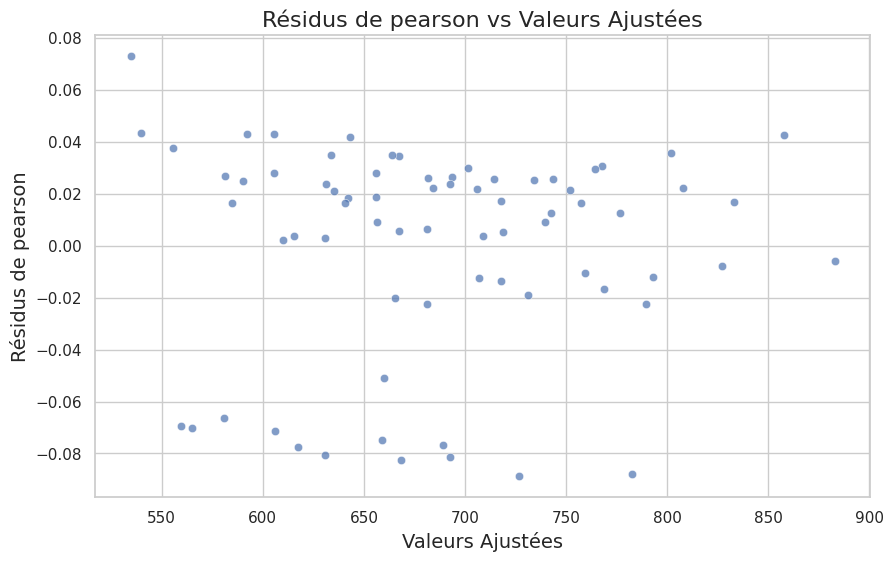

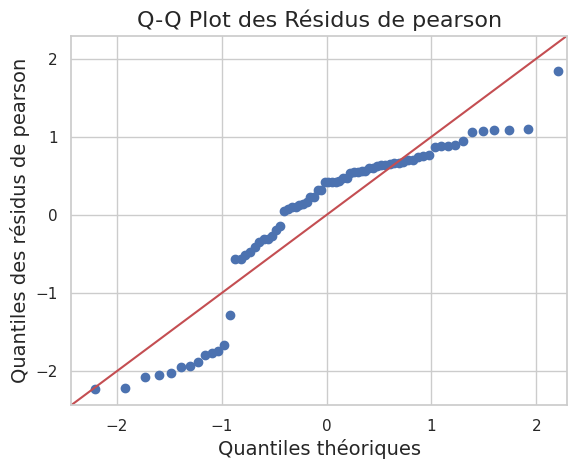

Variance Inflation Factor (VIF) :
                                      Variable       VIF
0                                        annee  1.000000
1                  region_Auvergne-Rhône-Alpes  1.833333
2               region_Bourgogne-Franche-Comté  1.833333
3                              region_Bretagne  1.833333
4                   region_Centre-Val-de-Loire  1.833333
5          region_Grand Est et Hauts-de-France  1.833333
6                             region_Normandie  1.833333
7                    region_Nouvelle-Aquitaine  1.833333
8                             region_Occitanie  1.833333
9                      region_Pays de la Loire  1.833333
10  region_Provence-Alpes-Côte d'Azur et Corse  1.833333
11  region_Régions et Départements d'outre-mer  1.833333


In [53]:
# 1. Analyse des résidus
residuals = glm_results.resid_pearson  # Résidus de déviance
fitted_values = glm_results.fittedvalues  # Valeurs ajustées

# Tracer les résidus vs valeurs ajustées
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.7)
#plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus de pearson vs Valeurs Ajustées", fontsize=16)
plt.xlabel("Valeurs Ajustées", fontsize=14)
plt.ylabel("Résidus de pearson", fontsize=14)
plt.show()

# 2. Q-Q Plot des résidus
sm.qqplot(residuals, line='45', dist=stats.norm, fit=True)
plt.title("Q-Q Plot des Résidus de pearson", fontsize=16)
plt.xlabel("Quantiles théoriques", fontsize=14)
plt.ylabel("Quantiles des résidus de pearson", fontsize=14)
plt.show()


# Test VIIF pour la multicolinéarité

# Calculer le VIF pour chaque variable
# Récupérer les données filtrées pour la période spécifiée (de 'year' à 'ending_year')
df = get_all_data_beginning_from_year(2019, 2024)

# Encoder les variables catégorielles (régions) en utilisant one-hot encoding
X = pd.get_dummies(df, columns=['region'], dtype=int)

# Supprimer la région Ile-de-France pour éviter la multicolinéarité (référence)
X.drop(columns=['region_Ile-de-France'], inplace=True)
X.drop(columns=['RAC_par_personne', 'RAC', 'population'], inplace=True)
X = sm.add_constant(X)  # Ajouter une constante pour l'intercept du modèle
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns[1:]
vif_data["VIF"] = [variance_inflation_factor(X.values, i+1) for i in range(X.shape[1]-1)]
print("Variance Inflation Factor (VIF) :")
print(vif_data)



### Analyse de coefficients significatif

In [54]:
# Afficher les p-values des résultats du modèle GLM
glm_results.pvalues

# Créer un DataFrame pour résumer les coefficients et leurs niveaux de significativité
coefficients_table = pd.DataFrame({
    'Coefficient': glm_results.params,  # Les coefficients estimés par le modèle
    'P-Value': glm_results.pvalues      # Les p-values associées aux coefficients
})

# Ajouter une colonne pour indiquer les niveaux de significativité en fonction des p-values
coefficients_table['Significance'] = coefficients_table['P-Value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else '_'
)

# Réinitialiser l'index pour inclure les noms des variables comme colonne
coefficients_table.reset_index(inplace=True)

# Renommer la colonne contenant les noms des variables
coefficients_table.rename(columns={'index': 'Variable'}, inplace=True)

# Afficher le tableau formaté des coefficients avec leurs niveaux de significativité
coefficients_table

,Variable,Coefficient,P-Value,Significance
0,const,-49986.329184,1.133727e-33,***
1,annee,25.105400,1.189233e-34,***
2,region_Auvergne-Rhône-Alpes,-58.138888,1.718051e-03,***
3,region_Bourgogne-Franche-Comté,-95.786431,1.192811e-07,***
4,region_Bretagne,-161.485311,1.213269e-20,***
5,region_Centre-Val-de-Loire,-109.354366,1.070879e-09,***
6,region_Grand Est et Hauts-de-France,-34.118285,7.015952e-02,*
7,region_Normandie,-120.317143,1.398878e-11,***
8,region_Nouvelle-Aquitaine,-67.740569,2.369060e-04,***
9,region_Occitanie,-37.442923,4.640343e-02,**


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Prédiction du reste à charge par personne en 2025 et 2026</b></h2>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Entrainement sur les années 2019 jusqu'à 2022, puis test sur les données de 2023 et 2024</b></h2>

In [55]:
# Préparation des données d'entraînement (2019-2023)
df_train = get_all_data_beginning_from_year(2019, 2023)

# Création des variables explicatives avec encodage one-hot pour les régions
X_train = pd.get_dummies(df_train, columns=['region'], dtype=int)
X_train.drop(columns=['region_Ile-de-France'], inplace=True)  # Région de référence
X_train = sm.add_constant(X_train)  # Ajout de la constante pour le modèle

# Définition de la variable à prédire
y_train = X_train['RAC_par_personne']

# Suppression des colonnes non utilisées dans le modèle
X_train.drop(columns=['RAC_par_personne', 'RAC', 'population'], inplace=True)

# Création et ajustement du modèle GLM avec une distribution Gaussienne
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gamma(sm.families.links.Identity()))
glm_results = glm_model.fit()

# Affichage des résultats du modèle
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       RAC_par_personne   No. Observations:                   60
Model:                            GLM   Df Residuals:                       47
Model Family:                   Gamma   Df Model:                           12
Link Function:               Identity   Scale:                       0.0022242
Method:                          IRLS   Log-Likelihood:                -286.57
Date:                Fri, 06 Jun 2025   Deviance:                      0.10742
Time:                        21:10:45   Pearson chi2:                    0.105
No. Iterations:                     9   Pseudo R-squ. (CS):             0.9968
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

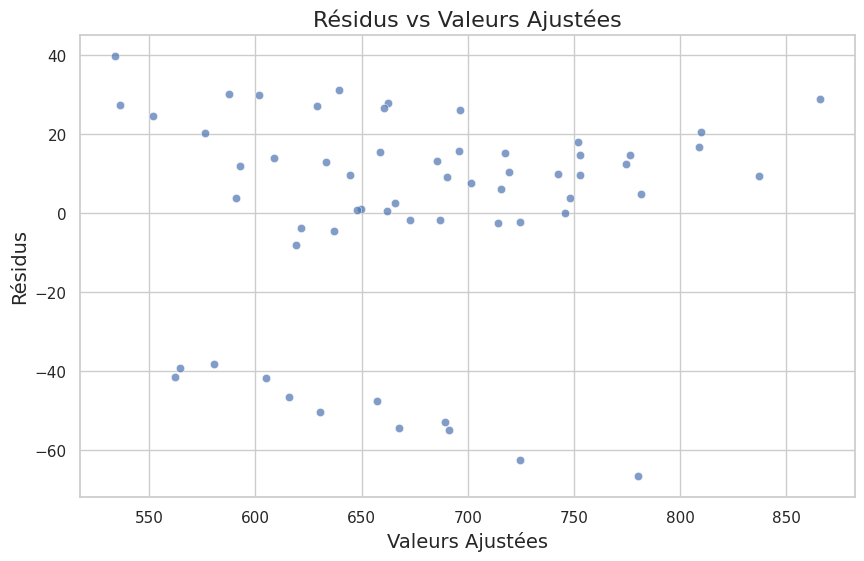

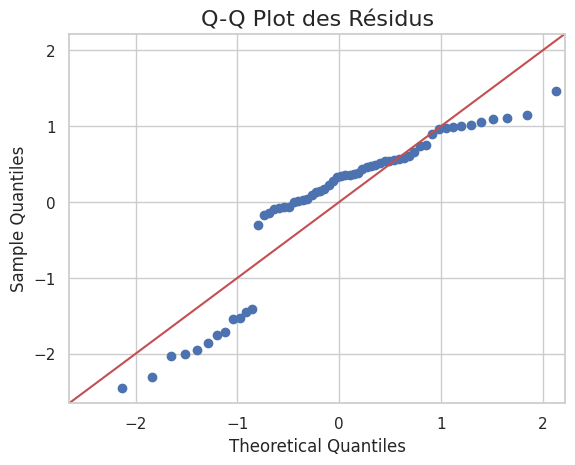

                                      Variable       VIF
0                                        annee  1.000000
1                  region_Auvergne-Rhône-Alpes  1.833333
2               region_Bourgogne-Franche-Comté  1.833333
3                              region_Bretagne  1.833333
4                   region_Centre-Val-de-Loire  1.833333
5          region_Grand Est et Hauts-de-France  1.833333
6                             region_Normandie  1.833333
7                    region_Nouvelle-Aquitaine  1.833333
8                             region_Occitanie  1.833333
9                      region_Pays de la Loire  1.833333
10  region_Provence-Alpes-Côte d'Azur et Corse  1.833333
11  region_Régions et Départements d'outre-mer  1.833333


In [56]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1. Analyse des résidus
residuals = glm_results.resid_response  # Résidus de réponse
fitted_values = glm_results.fittedvalues  # Valeurs ajustées

# Tracer les résidus vs valeurs ajustées
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.7)
#plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Valeurs Ajustées", fontsize=16)
plt.xlabel("Valeurs Ajustées", fontsize=14)
plt.ylabel("Résidus", fontsize=14)
plt.show()

# 2. Q-Q Plot des résidus
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot des Résidus", fontsize=16)
plt.show()

# 3. Multicollinearity
X = glm_results.model.exog  # Extract predictors
vif_data = pd.DataFrame({
    "Variable": glm_results.model.exog_names[1:],
    "VIF": [variance_inflation_factor(X, i + 1) for i in range(X.shape[1] - 1)]
})
print(vif_data)

In [57]:
# Récupération des données pour l'année 2024, en excluant certaines colonnes inutiles pour la prédiction
X_test = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'population', 'RAC_par_personne'])

# Application de l'encodage one-hot sur la colonne 'region' pour transformer les catégories en variables binaires
X_test = pd.get_dummies(X_test, columns=['region'],  dtype=int)
X_test.drop(columns=['region_Ile-de-France'], inplace=True)
# Alignement des colonnes de X_test avec celles de X_train pour garantir la cohérence des données
X_test = X_test.reindex(columns=X_train.columns, fill_value=1)

# Extraction des valeurs réelles de 'RAC_par_personne' pour l'année 2024
y_test = get_all_data_beginning_from_year(2024)['RAC_par_personne']

# Prédiction des valeurs de 'RAC_par_personne' à l'aide du modèle GLM entraîné
glm_model_predictions = glm_results.predict(X_test)

print("les résidus sont égaux à: ", np.mean(y_test - glm_model_predictions))

# Création d'un DataFrame pour comparer les valeurs réelles et prédites
Results_df = pd.concat(
    [
        X_test.reset_index(drop=True), 
        pd.DataFrame({'true_values': y_test.to_list(), 'predicted_values': glm_model_predictions.to_list()}).reset_index(drop=True)
    ], 
    axis=1
)

# Calcul et affichage de la MAPE (Mean Absolute Percentage Error) pour évaluer la précision du modèle
print("La MAPE pour le modèle GLM pour la prédiction du RAC est : {}%".format(round(mean_absolute_percentage_error(y_test, glm_model_predictions) * 100, 2)))

# Suppression des colonnes liées aux régions pour simplifier l'affichage des résultats
Results_df.drop(columns=[col for col in Results_df.columns if col.startswith('region')], inplace=True)


les résidus sont égaux à:  -25.48511007359241
La MAPE pour le modèle GLM pour la prédiction du RAC est : 3.57%


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Prédiction du RAC 2025 - 2026
</b></h2>

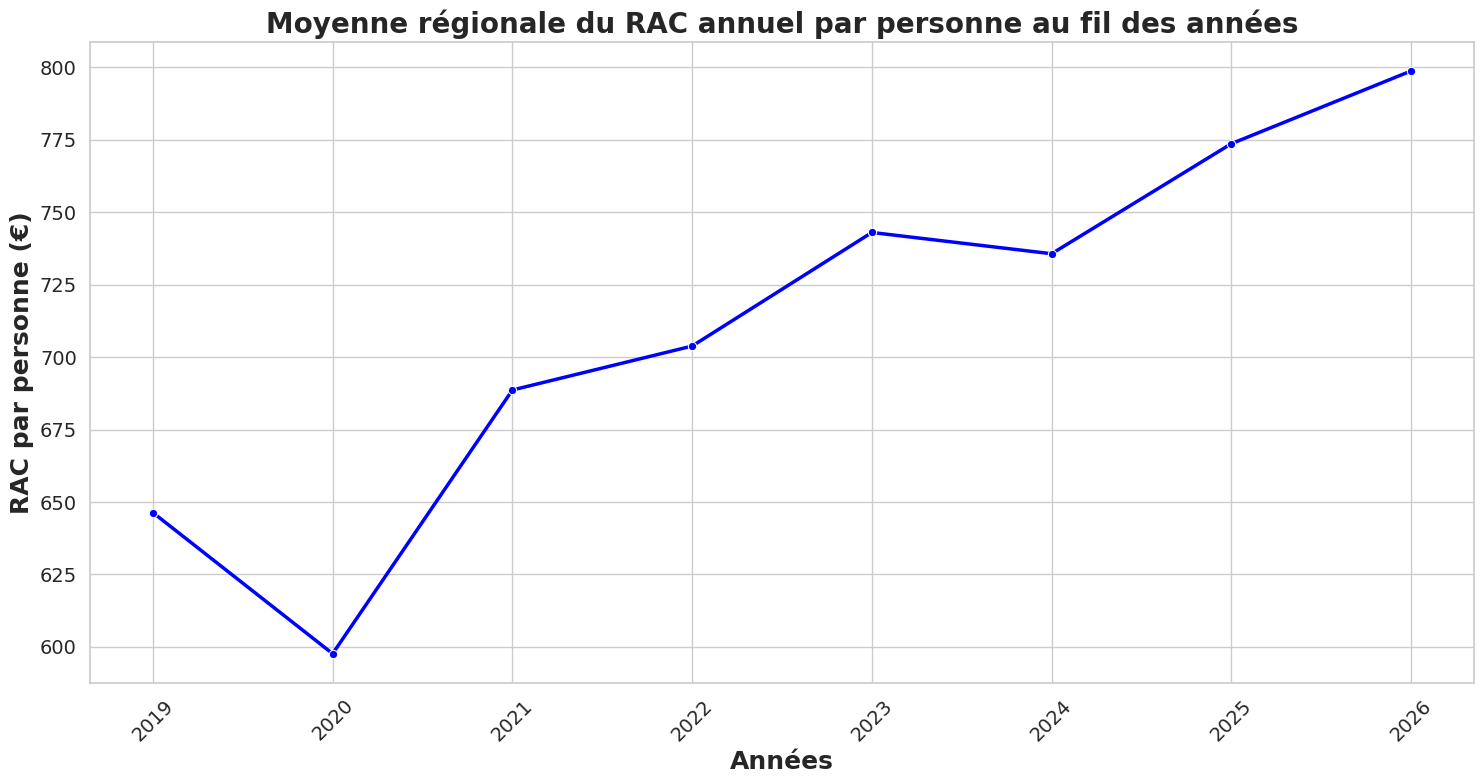

,annee,RAC_par_personne
0,2019,646.339427
1,2020,597.648571
2,2021,688.657991
3,2022,703.827216
4,2023,743.034274
5,2024,735.697225
0,2025,773.680397
0,2026,798.785797


In [58]:
final_glm_model, final_glm_results = GLM_model(2019,2024) # On entraine le modèle GLM sur toute la période de 2019 à 2024
data_prior_to_2024 = get_all_data_beginning_from_year(2019).drop(columns=['region', 'RAC', 'population']).groupby(['annee']).mean().reset_index()

# Préparer les données pour 2025
X_2025 = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'population', 'RAC_par_personne'])
X_2025 = pd.get_dummies(X_2025, columns=['region'], dtype=int)
X_2025.drop(columns=['region_Ile-de-France'], inplace=True)  # Assurer la cohérence avec X_train
X_2025 = X_test.reindex(columns=X_train.columns, fill_value=1)
X_2025['annee'] = 2025

# Préparer les données pour 2026
X_2026 = get_all_data_beginning_from_year(2024).drop(columns=['RAC', 'population', 'RAC_par_personne'])
X_2026 = pd.get_dummies(X_2026, columns=['region'],  dtype=int)
X_2026.drop(columns=['region_Ile-de-France'], inplace=True)  # Assurer la cohérence avec X_train
X_2026 = X_test.reindex(columns=X_train.columns, fill_value=1)
X_2026['annee'] = 2026

# Générer les prédictions pour 2025 et 2026
predictions_2025 = final_glm_results.predict(X_2025)
predictions_2026 = final_glm_results.predict(X_2026)

# Créer des DataFrames pour les prédictions
Results_2025_df = pd.concat(
    [X_2025.reset_index(drop=True), 
     pd.DataFrame({'RAC_par_personne': predictions_2025.to_list()}).reset_index(drop=True)], 
    axis=1
).drop(columns=['const'])

Results_2026_df = pd.concat(
    [X_2026.reset_index(drop=True), 
     pd.DataFrame({'RAC_par_personne': predictions_2026.to_list()}).reset_index(drop=True)], 
    axis=1
).drop(columns=['const'])

# Agréger les résultats par année et mois
Results_2025_agregated_df = Results_2025_df[['annee', 'RAC_par_personne']].groupby(by=['annee',]).mean().reset_index()
Results_2026_agregated_df = Results_2026_df[['annee', 'RAC_par_personne']].groupby(by=['annee',]).mean().reset_index()

# Combiner toutes les données temporelles
all_temporal_data = pd.concat([data_prior_to_2024, Results_2025_agregated_df, Results_2026_agregated_df])

# Ajouter une colonne datetime pour la visualisation


# Tracer l'évolution de RAC_par_personne au fil du temps
plt.figure(figsize=(15, 8))
sns.lineplot(data=all_temporal_data, x='annee', y='RAC_par_personne', marker='o', linewidth=2.5, color='blue')

# Ajouter un titre et des étiquettes
plt.title("Moyenne régionale du RAC annuel par personne au fil des années", fontsize=20, fontweight='bold')
plt.xlabel("Années", fontsize=18, fontweight='bold')
plt.ylabel("RAC par personne (€)", fontsize=18, fontweight='bold')

# Ajuster les ticks et la mise en page
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Afficher le graphique
plt.show()
all_temporal_data
